In [1]:
from pathlib import Path
from sys import stdout
import numpy as np
import pandas as pd
import itertools
from pymatgen import units
from pymatgen.transformations.standard_transformations import SupercellTransformation
import sympy
from scipy.constants import Boltzmann, electron_volt
from sympy import symbols
from sympy.vector import CoordSys3D

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression


from ruamel.yaml import YAML
yaml = YAML()

from neighbormodels.structure import from_file
from neighbormodels.neighbors import count_neighbors
from neighbormodels.interactions import build_model
import neighbormodels as nm

kB = 1000 * Boltzmann / electron_volt

pd.set_option("display.colheader_justify", "left")
pd.set_option("display.html.border", 0)
html_table_style = {"selector": "th", "props": [("text-align", "left")]}

In [2]:

def pattern_tables( layer, p_type):
    """
    Places the manetic patterns in the correct order relative to the structure file.
    
    Parameters:
    layer - magnetic patterns read in from file
    p_type - pre-fix for pattern
    """
    n_row, n_column = layer.shape
    au_layer = pd.DataFrame(np.zeros((2,n_column)))
    patterns = pd.concat([ layer[0:1],au_layer,
                           layer[1:2],au_layer,
                           layer[2:3],au_layer,
                           layer[3:4],au_layer,
                           layer[4:5],au_layer,
                           layer[5:6],au_layer,
                           layer[6:7],au_layer,
                           layer[7:8],au_layer], ignore_index=True)
    
    p_types =[]
    p_types.append("nm")
    index = np.arange(1,len(patterns.columns))
    for i in index:
        p_types.append(p_type+str(i))
    patterns.columns = p_types
    
    return patterns


def update_neighbors_data_frame(a, distances_list):
    """
    Updates the neighbor_data.data_frame to include only the Mn neighbor atoms 
    in the distances of interest.
    
    Parameters:
    
    a - neighbor_data.data_frame generated by count_neighbors function
    distances_list - list of distances of Mn neighbor atoms to consider
    
    """
    nn_distances = np.array(distances_list["distance"])
    idx_list_a = []
    for i in range(len(a['distance_bin'])):
        for j in nn_distances:
            if j in a['distance_bin'][i]:
                idx_list_a.append(i)
    drop_list_a = np.arange(len(a))
    drop_list_a = [i for i in drop_list_a if i not in idx_list_a]
    
    return a.drop(drop_list_a).reset_index(drop=True)

def neighbor_data_mod(structure_mnau2, distances_list):
    
    """
    Modifies the neighbor_data input with the update neighbor_data.data_frame
    
    Parameters:
    structure_mnau2 - pymatgen structure as read from .cif file
    distances_list - list of distances of Mn neighbor atoms to consider
    
    """
    k = nm.neighbors.NeighborData
    neighbor_data = count_neighbors(cell_structure=structure_mnau2, r=18.0)

    k.data_frame = neighbor_data.data_frame \
        .merge(neighbor_data.data_frame.rename(columns={"j": "i", "i": "j"}), how="outer") \
        .sort_values(["i","distance_bin", "j"]) \
         .query("subspecies_i != 'Au'")\
            .query("subspecies_j != 'Au'")#\
  #          .reset_index(drop=True)

    k.data_frame = update_neighbors_data_frame(k.data_frame, distances_list)

    k.bins_data_frame = neighbor_data.bins_data_frame
    k.count = neighbor_data.count
    k.index = neighbor_data.index
    k.structure = neighbor_data.structure
    
    return k

def drop_duplicate_energies(qe_energies):
    """
    Checks that energies are unique (not within tolerance value of each other)
    
    Parameters:
    
    qe_energies - list of energ values (read from file)
    
    """
    qe_energies.columns = ["pattern", "num_sites", "total_energy" ]
    ryd_to_ev = 13.605693009 #eV 
    tol = 0.0001 #eV

    #convert to eV
    qe_energies["total_energy"] = qe_energies["total_energy"]*ryd_to_ev

    for i in range(len(qe_energies)-1):
        for j in range(1+1,len(qe_energies)):
            if (i != j):
                diff = abs(qe_energies["total_energy"][i] - qe_energies["total_energy"][j])
                if (  diff  <= tol ):
                    qe_energies["pattern"][j] = qe_energies["pattern"][i]
                    #print (i,j, qe_energies["total_energy"][i], qe_energies["total_energy"][j], diff)
                
                
    #drop repeating energies            
    qe_energies = qe_energies.reset_index(drop=True).drop_duplicates(["pattern"], keep="first")           
 
    #convert back to Rydberg
    qe_energies["total_energy"] = qe_energies["total_energy"]/ryd_to_ev
    
    return qe_energies

def mg_moments_check(mg_moments, qe_energies):
    
    """
    Checks for no lost magnetic moments
    
    Parameters:
    
    mg_moments - table of magnetic moments read from file
    qe_energies - table of energies read from file
    
    """
    n_row, n_column = mg_moments.shape
    mg_moments = pd.DataFrame(round (abs(mg_moments/4.0)).sum(axis=0), columns=["total_moment"])
    mg_moments = pd.concat ([qe_energies['pattern'], mg_moments['total_moment']], axis=1)
    
    return mg_moments[(mg_moments['total_moment'] != n_row ) & (mg_moments['pattern'] != "nm") ] #.head()

#### Read in structure files and the table of distances for the Mn nearest neighbors:

In [3]:
cif_filepath1 = "data/mn8au16_collinear.cif"
cif_filepath2 = "data/mn8au16_1x1x4.cif"
structure_mnau2_c = from_file(structure_file=cif_filepath1)
structure_mnau2_z = from_file(structure_file=cif_filepath2)

distances_list=pd.read_csv('data/distances.csv-bak', header=None)
distances_list.columns= ['pattern','central_atom','neighbor_atom','distance']
distances_list

/home/ssilayi/anaconda3/lib/python3.6/site-packages/pymatgen/core/lattice.py:694: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(q.T, p.T)[0].T


,pattern,central_atom,neighbor_atom,distance
0,c,1,4,3.37
1,c,1,6,4.77
2,c,1,5,6.74
3,c,1,7,7.54
4,z,1,13,4.99
5,z,1,2,8.76
6,z,1,14,13.36
7,z,1,3,17.52


#### Using the structure files and distances list to update the output of count_neighbors. The updated input (modified neighbor_data.data_frame contains only the atom pairs in the distances of interest. This is the new input for build_model, which takes the magnetic patterns and the modified data_frame to generate the exchange model.

In [5]:
c_layer=pd.read_csv('data/mg_collinear_patterns', header=None)
c_patterns = pattern_tables( c_layer, "c-")
k_c = neighbor_data_mod(structure_mnau2_c, distances_list)
exchange_model_c = build_model(magnetic_patterns=c_patterns, neighbor_data=k_c)

z_layer=pd.read_csv('data/mg_1x1x4_patterns', header=None)
z_patterns = pattern_tables( z_layer, "z-")
k_z = neighbor_data_mod(structure_mnau2_z, distances_list)
exchange_model_z = build_model(magnetic_patterns=z_patterns, neighbor_data=k_z)

#### Combining the two exchange_model matrices into one large one. The number of neighbor energies listed is up to J8, same as the number of neighbors of interest in the distances_list.

In [6]:
#combine the 2 cases
exchange_model_all = pd.concat([exchange_model_c, exchange_model_z])\
                     .reset_index(drop=True)

exchange_model_all.to_csv("data/exchange_model.csv")    
exchange_model_all.head()


,pattern,J1,J2,J3,J4,J5,J6,J7,J8
0,c-1,0.000000,0.666667,0.666667,0.000000,0.000000,0.000000,0.666667,0.666667
1,c-10,-0.333333,0.000000,0.333333,0.000000,-0.666667,0.000000,0.333333,0.666667
2,c-11,-0.333333,0.000000,0.333333,0.000000,-0.666667,0.000000,0.333333,0.666667
3,c-12,0.333333,0.000000,1.000000,0.000000,0.666667,0.000000,1.000000,0.666667
4,c-13,0.000000,-1.333333,0.000000,1.333333,0.000000,-0.666667,0.000000,0.666667


In the next 2 steps, energies are read in and checked to eliminate any that duplicate. 
The magnetic moment from the calculations is also checked to make sure noe of the patterns lose it.

In [7]:
#Calculated energies from QE for the different patterns are tabulated and read in
qe_energies1 = pd.read_csv('data/energy.out.collinear.csv', header=None)
qe_energies_c = drop_duplicate_energies(qe_energies1) 

qe_energies2 = pd.read_csv('data/energy.out.1x1x4.csv', header=None)
qe_energies_z = drop_duplicate_energies(qe_energies2)    

#combine all energies
qe_energies_all = pd.concat([qe_energies_c, qe_energies_z])
qe_energies_all = qe_energies_all.reset_index(drop=True).drop_duplicates(["pattern"], keep="first") 
qe_energies_all.head()

/home/ssilayi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,pattern,num_sites,total_energy
0,nm,24,-14691.879405
1,c-1,24,-14693.951620
2,c-2,24,-14693.957454
3,c-3,24,-14693.970500
4,c-4,24,-14693.947722


In [8]:
#read in magnetic moments and return any that don't have the expected total magnetic moment (18)
mg_moments_c = pd.read_csv('data/mg_moment.collinear',sep='\t', header=None)
zero_moments_c = mg_moments_check(mg_moments_c, qe_energies_c)
#zero_moments_c

mg_moments_z = pd.read_csv('data/mg_moment.1x1x4',sep='\t', header=None)
zero_moments_z = mg_moments_check(mg_moments_z, qe_energies_z)
#zero_moments_z

#### The combined energies and exchange model matrices are put together for fitting of parameters:

In [9]:
def ModelMatrix(qe_energies, exchange_model):
    model_matrix = qe_energies \
        .assign(energy = lambda x:
            (x["total_energy"] -
             np.float64(x.query("pattern == 'nm'").loc[:, "total_energy"])) *
            1000 * units.Ha_to_eV / x["num_sites"])  \
        .merge(exchange_model, on=["pattern"]) \
        .query("pattern != 'nm'") \
        .assign(J1 = lambda x: x["J1"]) \
        .assign(J2 = lambda x: x["J2"]) \
        .assign(J3 = lambda x: x["J3"]) \
        .assign(J4 = lambda x: x["J4"]) \
        .assign(J5 = lambda x: x["J5"]) \
        .assign(J6 = lambda x: x["J6"]) \
        .assign(J7 = lambda x: x["J7"]) \
        .assign(J8 = lambda x: x["J8"]) \
        .loc[:, ["pattern", "energy", "J1", "J2", "J3", "J4", "J5" , "J6", "J7","J8"]]

    return model_matrix

model_matrix = ModelMatrix(qe_energies_all, exchange_model_all)\
               .reset_index(drop=True) \
               .drop(["pattern"], axis=1) 

model_matrix.head()
#model_matrix.tail()

,energy,J1,J2,J3,J4,J5,J6,J7,J8
0,-2349.493462,0.000000,0.666667,0.666667,0.000000,0.000000,0.000000,0.666667,0.666667
1,-2356.107643,0.333333,0.000000,1.000000,0.000000,0.666667,0.000000,1.000000,0.666667
2,-2370.898982,0.666667,0.666667,1.666667,0.666667,1.333333,0.333333,1.666667,0.666667
3,-2345.072973,-0.666667,0.666667,0.333333,0.666667,-1.333333,0.333333,0.333333,0.666667
4,-2343.546301,-0.333333,0.000000,0.333333,0.000000,-0.666667,0.000000,0.333333,0.666667


#### Parameters are fit (comparing 2 methods):

In this case, the values for the two come out different. Need to go over calculations again to make sure everything
works as intended (haven't found anything yet)

In [10]:
smf_exchange_fit = smf.ols(data=model_matrix, formula="energy ~ J1 + J2 + J3 + J4 +J5 + J6 + J7 + J8 ").fit()
smf_exchange_parameters = pd.DataFrame(smf_exchange_fit.params, columns=["stats_models"])
#smf_exchange_parameters


In [11]:
lm = LinearRegression()
lm_exchange_fit = lm.fit(X=model_matrix[["J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"]], y=model_matrix["energy"])
lm_exchange_parameters = pd.DataFrame({
    "sklearn": [lm_exchange_fit.intercept_, 
                lm_exchange_fit.coef_[0], lm_exchange_fit.coef_[1],lm_exchange_fit.coef_[2],
                lm_exchange_fit.coef_[3], lm_exchange_fit.coef_[4],lm_exchange_fit.coef_[5],
                lm_exchange_fit.coef_[6], lm_exchange_fit.coef_[7]]},
    index=["Intercept", "J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"],
)
#lm_exchange_parameters

In [12]:
exchange_parameters = pd.concat([smf_exchange_parameters,lm_exchange_parameters], axis=1)
#save to file    
exchange_parameters.to_csv("data/mnau2_exchange_parameters.select_neighbors.txt", sep=' ')
exchange_parameters

,stats_models,sklearn
Intercept,-1392.593073,-2.375600e+03
J1,107.575647,-1.647339e+00
J2,-14.566119,-1.456612e+01
J3,-274.682093,-1.624628e+00
J4,5.964567,5.964567e+00
J5,215.151294,-3.294678e+00
J6,546.137641,2.271066e-02
J7,-274.682093,-1.624628e+00
J8,-928.395382,-3.332017e-30


#### The parameters are supposed to reproduce the calculated total energies with a shift.

<Figure size 432x288 with 0 Axes>

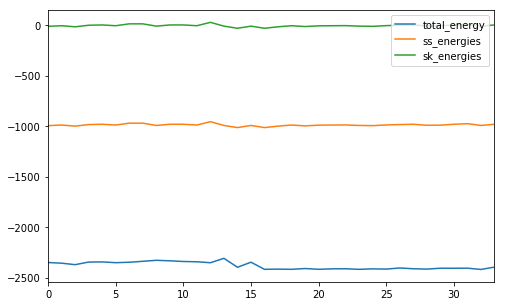

In [34]:
sk_par = lm_exchange_parameters.drop(lm_exchange_parameters.index[0])
ss_par = smf_exchange_parameters.drop(smf_exchange_parameters.index[0])

par_table =["J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"]
neighbor_energies = model_matrix[par_table].copy().reset_index(drop=True)

a = neighbor_energies.values 

b = ss_par.transpose().values
ss_energies = np.sum(a*b, axis =1 )

b = sk_par.transpose().values
sk_energies = np.sum(a*b, axis =1 )

energies = pd.DataFrame()
energies["total_energy"] = model_matrix["energy"]
energies["ss_energies"] = ss_energies
energies["sk_energies"] = sk_energies

import matplotlib.pyplot as plt
#features=["total_energy", "ss_energy", "sk_energy"]
plt.figure()
energies.plot( figsize=(8,5));
plt.show()

In [32]:
from sklearn.metrics import mean_squared_error as mse
np.sqrt(mse(energies["total_energy"], energies["ss_energies"])), np.sqrt(mse(energies["total_energy"], energies["sk_energies"]))


(1392.988277000842, 2375.8316405268174)

In [33]:
#constant difference between sk_energies and ss_energies
energies.ss_energies - energies.sk_energies

0    -983.006875
1    -983.006875
2    -983.006875
3    -983.006875
4    -983.006875
5    -983.006875
6    -983.006875
7    -983.006875
8    -983.006875
9    -983.006875
10   -983.006875
11   -983.006875
12   -983.006875
13   -983.006875
14   -983.006875
15   -983.006875
16   -983.006875
17   -983.006875
18   -983.006875
19   -983.006875
20   -983.006875
21   -983.006875
22   -983.006875
23   -983.006875
24   -983.006875
25   -983.006875
26   -983.006875
27   -983.006875
28   -983.006875
29   -983.006875
30   -983.006875
31   -983.006875
32   -983.006875
33   -983.006875
dtype: float64